# Training a PolymerGNN to predict IV
This notebook shows:
1. How to load the dataset
2. How to train the model
3. How to save and load the model via state dictionaries
4. How to visualize model predictions

In [1]:
import os
import torch
import pandas as pd
from polymerlearn.utils import get_IV_add, GraphDataset

# Load data from local path:
data = pd.read_csv('../dataset/pub_data.csv')

# Get additional variables:
add = get_IV_add(data)  #also loads mw, tmp%, amount of OH, ... from the csv file

# Load in specialized dataset class:
dataset = GraphDataset(
    data = data,
    Y_target=['IV'],
    test_size = 0.2,
    add_features=add
)

C:\Users\wanne\AppData\Local\Temp\ipykernel_3864\593630254.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
c:\Users\wanne\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
c:\users\wanne\documents\school\master_2\2e_semester\master_thesis\vs_code\polymergnn-main\polymerlearn\utils\graph_prep.py:452: RuntimeWarning: invalid value encountered in greater
  acid_hit = (data.iloc[i,ac[0]:ac[1]].to_numpy() > 0)
c:\users\wanne\documents\school\master_2\2e_semeste

        IV
0    0.279
1    0.321
2    0.272
3    0.257
4    0.260
..     ...
291  0.584
292  0.587
293  0.538
294  0.357
295  0.548

[296 rows x 1 columns]


Now we'll instantiate our model, using the standard IV model that gets the best prediction scores.

In [2]:
from polymerlearn.models.gnn import PolymerGNN_IV
from polymerlearn.utils import train

model = PolymerGNN_IV(
    input_feat = 6,         # How many input features on each node; don't change this
    hidden_channels = 32,   # How many intermediate dimensions to use in model
                            # Can change this ^^
    num_additional = 4      # How many additional resin properties to include in the prediction
                            # Corresponds to the number in get_IV_add
)

optimizer = torch.optim.AdamW(model.parameters(), lr = 0.0001, weight_decay=0.01)
criterion = torch.nn.MSELoss()

train(
    model,
    optimizer = optimizer,
    criterion = criterion,
    dataset = dataset,
    batch_size = 64,
    epochs = 800
)

c:\users\wanne\documents\school\master_2\2e_semester\master_thesis\vs_code\polymergnn-main\polymerlearn\utils\graph_prep.py:610: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ..\torch\csrc\utils\tensor_new.cpp:278.)
  torch.tensor(self.add_test).float().to(self.device)


Epoch: 0, 	 Train r2: -10.6887 	 Train Loss: 35.0410 	 Test r2: -2.4354 	 Test Loss 0.1531
Epoch: 10, 	 Train r2: 0.0962 	 Train Loss: 1.8830 	 Test r2: 0.4600 	 Test Loss 0.0241
Epoch: 20, 	 Train r2: 0.2407 	 Train Loss: 2.8239 	 Test r2: 0.4909 	 Test Loss 0.0227
Epoch: 30, 	 Train r2: 0.2542 	 Train Loss: 2.0266 	 Test r2: 0.4571 	 Test Loss 0.0242
Epoch: 40, 	 Train r2: 0.4655 	 Train Loss: 1.1432 	 Test r2: 0.5089 	 Test Loss 0.0219
Epoch: 50, 	 Train r2: 0.4349 	 Train Loss: 1.4544 	 Test r2: 0.5750 	 Test Loss 0.0189
Epoch: 60, 	 Train r2: 0.4390 	 Train Loss: 1.3000 	 Test r2: 0.5982 	 Test Loss 0.0179
Epoch: 70, 	 Train r2: 0.4054 	 Train Loss: 2.2596 	 Test r2: 0.6308 	 Test Loss 0.0165
Epoch: 80, 	 Train r2: 0.3733 	 Train Loss: 2.5994 	 Test r2: 0.5044 	 Test Loss 0.0221
Epoch: 90, 	 Train r2: 0.3431 	 Train Loss: 1.5647 	 Test r2: 0.6046 	 Test Loss 0.0176
Epoch: 100, 	 Train r2: 0.4989 	 Train Loss: 2.2321 	 Test r2: 0.6931 	 Test Loss 0.0137
Epoch: 110, 	 Train r2: 0.51

Since you now have a trained model, we can feed in some of the test data and observe outputs.

In [3]:
from polymerlearn.utils import make_like_batch

test_data, Ytest, add_test = dataset.get_test()
add_test = torch.tensor(add_test).float()

predictions = []
model.eval()
with torch.no_grad():
    for i in range(Ytest.shape[0]):
        batch_like_tup = make_like_batch(test_data[i])
        pred = model(*batch_like_tup, add_test[i]).item()
        predictions.append(pred)

C:\Users\wanne\AppData\Local\Temp\ipykernel_3864\3037405712.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  add_test = torch.tensor(add_test).float()


The next code block shows how we can save the model into a state dictionary object, which is PyTorch's main tool for storing model data. Read more about state dictionaries here: https://pytorch.org/tutorials/beginner/saving_loading_models.html 

In [4]:
# Save state dictionary of trained model:
torch.save(model.state_dict(), 'my_model.pth')

We can then load the code back into a separate model. This new model will contain the same weights, i.e. the same composition and predictive capabilities, as the old model that we saved above. 

In [5]:
# Keep below parameters the exact same if you want to load in a state dictionary
model2 = PolymerGNN_IV(
    input_feat = 6,         
    hidden_channels = 32,   
    num_additional = 4      
)
model2.load_state_dict(torch.load('my_model.pth'))

# Get simultaneous predictions, show they're the same:
batch_0 = make_like_batch(test_data[0])
pred1 = model(*batch_0, add_test[0]).item()
pred2 = model2(*batch_0, add_test[0]).item()

print(test_data[0])
print('Prediction 1', pred1)
print('Prediction 2', pred2)


([Data(x=[14, 6], edge_index=[2, 26], y=[1], pct=[1]), Data(x=[18, 6], edge_index=[2, 36], y=[1], pct=[1]), Data(x=[18, 6], edge_index=[2, 36], y=[1], pct=[1])], [Data(x=[19, 6], edge_index=[2, 36], y=[1], pct=[1]), Data(x=[26, 6], edge_index=[2, 52], y=[1], pct=[1])])
Prediction 1 0.28975343704223633
Prediction 2 0.28975343704223633


Now we'll generate a scatterplot that compares predictions for the test set and the ground truth values.

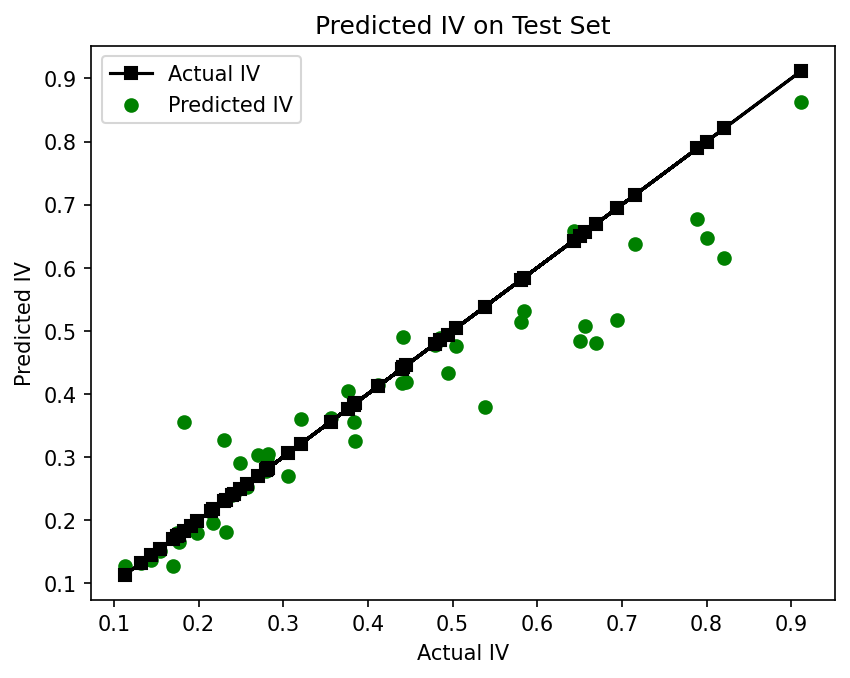

In [6]:
import matplotlib.pyplot as plt

Y = Ytest.tolist()

plt.figure(dpi=150)
plt.plot(Y, Y, marker = 's', c = 'black', label = 'Actual IV')
plt.scatter(Y, predictions, c = 'green', label = 'Predicted IV')
plt.xlabel('Actual IV')
plt.ylabel('Predicted IV')
plt.title('Predicted IV on Test Set')
plt.legend()
plt.show()